In [2]:
!pip install cartopy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 71.8 MB/s eta 0:00:00


In [3]:
import os
import urllib.request
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import LineString
import cartopy.crs as ccrs
import matplotlib.patches as mpatches
import numpy as np
import matplotlib.colors as mcolors
from pyproj import Geod
import matplotlib.animation as animation
import matplotlib.lines as mlines
from matplotlib.patches import FancyArrow

In [5]:
# Download and save Airport Data

# File path in Google Drive
airport_file = "/content/drive/MyDrive/Flight_Route_of_India/Airport/airports.dat"
airport_url = "https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat"

# Ensure directory exists
os.makedirs(os.path.dirname(airport_file), exist_ok=True)

# Download file
urllib.request.urlretrieve(airport_url, airport_file)

print("Download completed:", airport_file)

Download completed: /content/drive/MyDrive/Flight_Route_of_India/Airport/airports.dat


In [4]:
airports = pd.read_csv("/content/drive/MyDrive/Flight_Route_of_India/Airport/airports.dat", delimiter=',',
                       names=['id', 'name', 'city', 'country', 'iata',
                              'icao', 'lat', 'long', 'altitude', 'timezone',
                              'dst', 'tz', 'type', 'source'])
airports.head()

,id,name,city,country,iata,icao,lat,long,altitude,timezone,dst,tz,type,source
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10,U,Pacific/Port_Moresby,airport,OurAirports
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20,10,U,Pacific/Port_Moresby,airport,OurAirports
2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10,U,Pacific/Port_Moresby,airport,OurAirports
3,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10,U,Pacific/Port_Moresby,airport,OurAirports
4,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146,10,U,Pacific/Port_Moresby,airport,OurAirports


In [5]:
# ---- Filter Indian Airports ----
ind_airport = airports[(airports['country'] == 'India') & (airports['iata'] != '\\N')]

# Convert to GeoDataFrame (like st_as_sf in R)
ind_airport_sf = gpd.GeoDataFrame(
    ind_airport,
    geometry=gpd.points_from_xy(ind_airport["long"], ind_airport["lat"]),
    crs="EPSG:4326"
)

# Create a DataFrame with lon/lat columns (similar to mutate in R)
ind_airport_df = ind_airport.copy()
ind_airport_df["long"] = ind_airport_df["long"]
ind_airport_df["lat"] = ind_airport_df["lat"]

# Preview
print(ind_airport_sf.head())

        id                                            name        city  \
2836  2994  Sardar Vallabhbhai Patel International Airport   Ahmedabad   
2837  2995                                   Akola Airport       Akola   
2838  2996                              Aurangabad Airport  Aurangabad   
2839  2997       Chhatrapati Shivaji International Airport      Mumbai   
2840  2998                                Bilaspur Airport    Bilaspur   

     country iata  icao        lat       long  altitude timezone dst  \
2836   India  AMD  VAAH  23.077200  72.634697       189      5.5   N   
2837   India  AKD  VAAK  20.698999  77.058601       999      5.5   N   
2838   India  IXU  VAAU  19.862700  75.398102      1911      5.5   N   
2839   India  BOM  VABB  19.088699  72.867897        39      5.5   N   
2840   India  PAB  VABI  21.988400  82.111000       899      5.5   N   

                 tz     type       source                 geometry  
2836  Asia/Calcutta  airport  OurAirports  POINT (72.

/usr/local/lib/python3.12/dist-packages/pyogrio/raw.py:198: RuntimeWarning: /content/drive/MyDrive/Flight_Route_of_India/IND_Boundary/India_Boundary.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


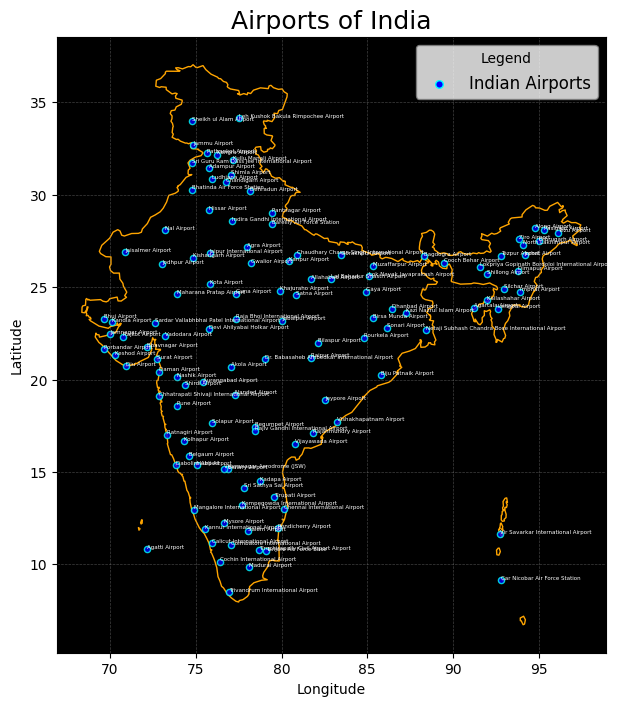

Map saved to: /content/drive/MyDrive/Flight_Route_of_India/Airports of India.png


In [8]:
# --- Plot map ---

IND_Boundary = gpd.read_file("/content/drive/MyDrive/Flight_Route_of_India/IND_Boundary/India_Boundary.shp")

fig, ax = plt.subplots(figsize=(12, 8))

ax.set_facecolor('black')  # Axes background

# Plot India boundary
IND_Boundary.plot(ax=ax, color='none', edgecolor='orange', linewidth=1)

# Plot Indian airports
ax.scatter(ind_airport['long'], ind_airport['lat'],
           s=20, color='blue', alpha=0.8, edgecolors='cyan')

# Add airport names in black font
for idx, row in ind_airport.iterrows():
    ax.text(row['long'], row['lat'], row['name'], fontsize=4, color='white', ha='left', va='bottom')

# Add legend
ax.scatter([], [], s=30, color='blue', edgecolors='cyan', label='Indian Airports')
ax.legend(loc='upper right', fontsize=12, facecolor='white', edgecolor='gray', title='Legend')

# Add gridlines for latitude and longitude
ax.grid(True, which='both', linestyle='--', color='gray', alpha=0.5, linewidth=0.5)

# Label axes
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

ax.set_title("Airports of India", fontsize=18)

# --- Step 5: Save figure ---
output_file = "/content/drive/MyDrive/Flight_Route_of_India/Airports of India.png"
plt.savefig(output_file, dpi=1200, bbox_inches='tight')

plt.show()

print(f"Map saved to: {output_file}")

In [17]:
# Download and save Airport Route Data

# File path in Google Drive
airport_route_file = "/content/drive/MyDrive/Flight_Route_of_India/Routes/routes.dat"
airport_route_url = "https://raw.githubusercontent.com/jpatokal/openflights/master/data/routes.dat"

# Ensure directory exists
os.makedirs(os.path.dirname(airport_route_file), exist_ok=True)

# Download file
urllib.request.urlretrieve(airport_route_url, airport_route_file)

print("Download completed:", airport_route_file)

Download completed: /content/drive/MyDrive/Flight_Route_of_India/Routes/routes.dat


In [6]:
routes = pd.read_csv("/content/drive/MyDrive/Flight_Route_of_India/Routes/routes.dat", delimiter=',', names=['airline', 'id', 'source_airport', 'source_airport_id',
                                                               'destination_airport', 'destination_airport_id', 'codeshare',
                                                               'stops', 'equitment'])
routes.head()

,airline,id,source_airport,source_airport_id,destination_airport,destination_airport_id,codeshare,stops,equitment
0,2B,410,AER,2965,KZN,2990,NaN,0,CR2
1,2B,410,ASF,2966,KZN,2990,NaN,0,CR2
2,2B,410,ASF,2966,MRV,2962,NaN,0,CR2
3,2B,410,CEK,2968,KZN,2990,NaN,0,CR2
4,2B,410,CEK,2968,OVB,4078,NaN,0,CR2


In [7]:
#-----Filter routes that involve Indian airports-----

ind_airports_iata = set(ind_airport['iata'])

ind_routes = routes[
    routes['source_airport'].isin(ind_airports_iata) |
    routes['destination_airport'].isin(ind_airports_iata)
]
print(ind_routes)

      airline     id source_airport source_airport_id destination_airport  \
1027       4H   8463            CCU              3043                 CGP   
1028       4H   8463            CCU              3043                 DAC   
1029       4H   8463            CGP              3069                 CCU   
1035       4H   8463            DAC              3076                 CCU   
1196       4Q  10758            DEL              3093                 HEA   
...       ...    ...            ...               ...                 ...   
65131      WY   3778            MCT              2194                 JAI   
65140      WY   3778            MCT              2194                 LKO   
65141      WY   3778            MCT              2194                 MAA   
65148      WY   3778            MCT              2194                 TRV   
65161      WY   3778            TRV              3153                 MCT   

      destination_airport_id codeshare  stops equitment  
1027             

In [8]:
# Merge source airport coordinates
ind_routes = ind_routes.merge(
    ind_airport[['iata', 'lat', 'long']],
    left_on='source_airport',
    right_on='iata',
    how='left'
).rename(columns={'lat': 'source_lat', 'long': 'source_long'}).drop(columns=['iata'])

# Merge destination airport coordinates
ind_routes = ind_routes.merge(
    ind_airport[['iata', 'lat', 'long']],
    left_on='destination_airport',
    right_on='iata',
    how='left'
).rename(columns={'lat': 'dest_lat', 'long': 'dest_long'}).drop(columns=['iata'])

In [9]:
print(ind_routes.dtypes)
print(ind_routes.head())


airline                    object
id                         object
source_airport             object
source_airport_id          object
destination_airport        object
destination_airport_id     object
codeshare                  object
stops                       int64
equitment                  object
source_lat                float64
source_long               float64
dest_lat                  float64
dest_long                 float64
dtype: object
  airline     id source_airport source_airport_id destination_airport  \
0      4H   8463            CCU              3043                 CGP   
1      4H   8463            CCU              3043                 DAC   
2      4H   8463            CGP              3069                 CCU   
3      4H   8463            DAC              3076                 CCU   
4      4Q  10758            DEL              3093                 HEA   

  destination_airport_id codeshare  stops equitment  source_lat  source_long  \
0                   3069 

In [10]:
# First, check for duplicate columns
ind_routes = ind_routes.loc[:, ~ind_routes.columns.duplicated()]

# Keep only the final coordinate columns you need
keep_cols = ['airline', 'source_airport', 'destination_airport',
             'source_lat', 'source_long', 'dest_lat', 'dest_long']
ind_routes_clean = ind_routes[keep_cols].copy()

# Convert coordinates to numeric
for col in ['source_lat', 'source_long', 'dest_lat', 'dest_long']:
    ind_routes_clean[col] = pd.to_numeric(ind_routes_clean[col], errors='coerce')

# Drop rows with missing coords
ind_routes_clean = ind_routes_clean.dropna(subset=['source_lat', 'source_long', 'dest_lat', 'dest_long'])

In [11]:
# Build GeoDataFrame

from shapely.geometry import LineString
import geopandas as gpd

ind_routes_clean['geometry'] = ind_routes_clean.apply(
    lambda row: LineString([(row['source_long'], row['source_lat']),
                            (row['dest_long'], row['dest_lat'])]), axis=1)

# Convert to GeoDataFrame
ind_routes_gdf = gpd.GeoDataFrame(ind_routes_clean, geometry='geometry', crs="EPSG:4326")

/usr/local/lib/python3.12/dist-packages/pyogrio/raw.py:198: RuntimeWarning: /content/drive/MyDrive/Flight_Route_of_India/IND_Boundary/India_Boundary.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


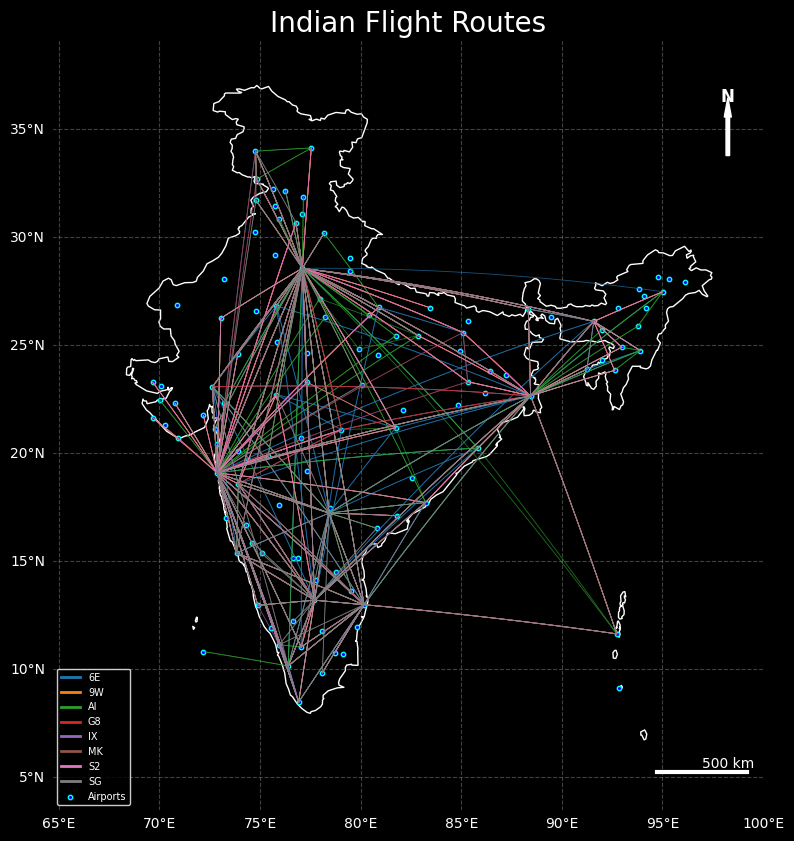

In [39]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.colors as mcolors
import geopandas as gpd
from pyproj import Geod
from matplotlib.patches import FancyArrow

# --------------------- Custom Scale Bar Function ---------------------
def add_scale_bar(ax, length_km=500, location=(0.85, 0.05), linewidth=3, color='white'):
    """Add a simple scale bar to a cartopy axis."""
    lon0, lon1, lat0, lat1 = ax.get_extent(ccrs.PlateCarree())
    x_frac, y_frac = location
    lon_start = lon0 + (lon1 - lon0) * x_frac
    lat_start = lat0 + (lat1 - lat0) * y_frac

    # Draw scale bar line
    ax.plot([lon_start, lon_start + length_km / 111], [lat_start, lat_start],
            transform=ccrs.PlateCarree(), color=color, linewidth=linewidth)

    # Add text label
    ax.text(lon_start + (length_km / (2*111)), lat_start + 0.2,
            f"{length_km} km", transform=ccrs.PlateCarree(),
            color=color, fontsize=10)

# --------------------- North Arrow Function ---------------------
def add_north_arrow(ax, location=(0.95, 0.85), width=0.005, height=0.05, pad=0.02, color='white'):
    """Add a simple north arrow to a cartopy axis."""
    bbox = ax.get_position()
    ax_width = bbox.width
    ax_height = bbox.height
    ax_x = bbox.x0
    ax_y = bbox.y0

    x_frac, y_frac = location
    x_start = ax_x + ax_width * x_frac
    y_start = ax_y + ax_height * y_frac

    arrow = FancyArrow(
        x_start, y_start,
        0, ax_height * height,
        width=ax_width * width,
        head_width=ax_width * width * 2,
        head_length=ax_height * height / 2,
        transform=ax.figure.transFigure,
        color=color
    )
    ax.figure.patches.append(arrow)

    # Add "N" label
    ax.figure.text(x_start, y_start + ax_height * (height + pad), "N",
                   color=color, fontsize=12, fontweight="bold", ha="center")

# --------------------- Colors ---------------------
colors = list(mcolors.TABLEAU_COLORS.values())

# --------------------- Setup Figure ---------------------
fig, ax = plt.subplots(
    figsize=(16, 10),
    subplot_kw={'projection': ccrs.PlateCarree()},
    facecolor='black'
)
ax.set_facecolor('black')

# --------------------- India Boundary ---------------------
IND_Boundary = gpd.read_file("/content/drive/MyDrive/Flight_Route_of_India/IND_Boundary/India_Boundary.shp")
IND_Boundary.to_crs(epsg=4326).plot(
    ax=ax, edgecolor='white', facecolor='none', linewidth=1
)

# --------------------- Map Extent ---------------------
min_lon = min(ind_routes_clean['source_long'].min(),
              ind_routes_clean['dest_long'].min()) - 5
max_lon = max(ind_routes_clean['source_long'].max(),
              ind_routes_clean['dest_long'].max()) + 5
min_lat = min(ind_routes_clean['source_lat'].min(),
              ind_routes_clean['dest_lat'].min()) - 5
max_lat = max(ind_routes_clean['source_lat'].max(),
              ind_routes_clean['dest_lat'].max()) + 5

ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

geod = Geod(ellps='WGS84')

groups = ind_routes_clean.groupby('airline')
for i, (airline, group) in enumerate(groups):
    color = colors[i % len(colors)]
    for _, row in group.iterrows():
        npts = 100
        points = geod.npts(
            row['source_long'], row['source_lat'],
            row['dest_long'], row['dest_lat'],
            npts
        )
        lons, lats = zip(*points)

        lons = [row['source_long']] + list(lons) + [row['dest_long']]
        lats = [row['source_lat']] + list(lats) + [row['dest_lat']]

        ax.plot(
            lons,
            lats,
            color=color,
            linewidth=0.6,
            alpha=0.7,
            transform=ccrs.Geodetic()
        )

    ax.plot([], [], color=color, linewidth=2, label=airline)

# --------------------- Plot Airports ---------------------
ind_airport_sf.plot(ax=ax, color='blue', markersize=10, edgecolor='cyan', label="Airports")

# --------------------- Gridlines ---------------------
gl = ax.gridlines(draw_labels=True, linestyle='--', color='gray', alpha=0.5, linewidth=0.8)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'color': 'white'}
gl.ylabel_style = {'color': 'white'}

# --------------------- Title & Legend ---------------------
ax.set_title("Indian Flight Routes", fontsize=20, color='white')
ax.legend(loc='lower left', fontsize=7, facecolor='black', edgecolor='white', labelcolor='white')

# --------------------- Add Scale Bar & North Arrow ---------------------
add_scale_bar(ax, length_km=500, location=(0.85, 0.05))
add_north_arrow(ax, location=(0.95, 0.85))

# --------------------- Save & Show ---------------------
plt.savefig(
    "/content/drive/MyDrive/Flight_Route_of_India/Indian_Flight_Routes.png",
    dpi=1200, bbox_inches='tight', facecolor='black'
)
plt.show()


/usr/local/lib/python3.12/dist-packages/pyogrio/raw.py:198: RuntimeWarning: /content/drive/MyDrive/Flight_Route_of_India/IND_Boundary/India_Boundary.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


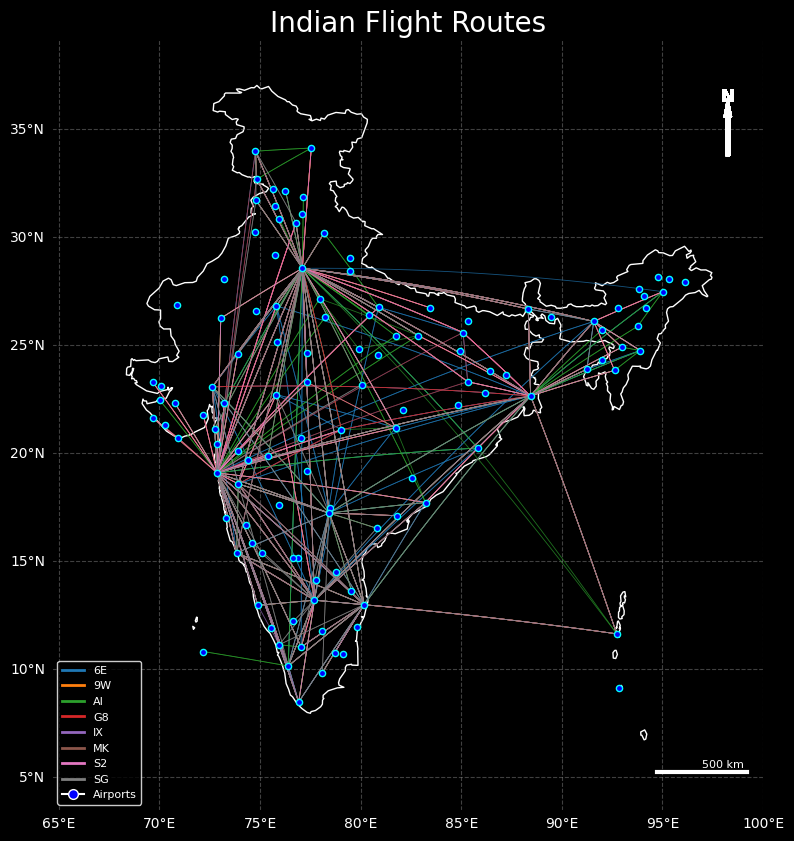

In [12]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import cartopy.crs as ccrs
import matplotlib.colors as mcolors
import geopandas as gpd
from pyproj import Geod
import matplotlib.lines as mlines
from matplotlib.patches import FancyArrow

# --------------------- Custom Scale Bar Function ---------------------
def add_scale_bar(ax, length_km=500, location=(0.85, 0.05), linewidth=3, color='white'):
    """Add a simple scale bar to a cartopy axis."""
    lon0, lon1, lat0, lat1 = ax.get_extent(ccrs.PlateCarree())
    x_frac, y_frac = location
    lon_start = lon0 + (lon1 - lon0) * x_frac
    lat_start = lat0 + (lat1 - lat0) * y_frac

    # Draw scale bar line
    ax.plot([lon_start, lon_start + length_km / 111], [lat_start, lat_start],
            transform=ccrs.PlateCarree(), color=color, linewidth=linewidth)

    # Add text label
    ax.text(lon_start + (length_km / (2*111)), lat_start + 0.2,
            f"{length_km} km", transform=ccrs.PlateCarree(),
            color=color, fontsize=8)

# --------------------- North Arrow Function ---------------------
def add_north_arrow(ax, location=(0.95, 0.85), width=0.005, height=0.05, pad=0.02, color='white'):
    """Add a simple north arrow to a cartopy axis."""
    bbox = ax.get_position()
    ax_width = bbox.width
    ax_height = bbox.height
    ax_x = bbox.x0
    ax_y = bbox.y0

    x_frac, y_frac = location
    x_start = ax_x + ax_width * x_frac
    y_start = ax_y + ax_height * y_frac

    arrow = FancyArrow(
        x_start, y_start,
        0, ax_height * height,
        width=ax_width * width,
        head_width=ax_width * width * 2,
        head_length=ax_height * height / 2,
        transform=ax.figure.transFigure,
        color=color
    )
    ax.figure.patches.append(arrow)

    # Add "N" label
    ax.figure.text(x_start, y_start + ax_height * (height + pad), "N",
                   color=color, fontsize=12, fontweight="bold", ha="center")

# --------------------- Colors ---------------------
colors = list(mcolors.TABLEAU_COLORS.values())

# --------------------- Setup Figure ---------------------
fig, ax = plt.subplots(
    figsize=(16, 10),
    subplot_kw={'projection': ccrs.PlateCarree()},
    facecolor='black'
)
ax.set_facecolor('black')

# --------------------- India Boundary ---------------------
IND_Boundary = gpd.read_file("/content/drive/MyDrive/Flight_Route_of_India/IND_Boundary/India_Boundary.shp")
IND_Boundary = IND_Boundary.to_crs(epsg=4326)
IND_Boundary.plot(ax=ax, edgecolor='white', facecolor='none', linewidth=1)

# --------------------- Map Extent ---------------------
min_lon = min(ind_routes_clean['source_long'].min(),
              ind_routes_clean['dest_long'].min()) - 5
max_lon = max(ind_routes_clean['source_long'].max(),
              ind_routes_clean['dest_long'].max()) + 5
min_lat = min(ind_routes_clean['source_lat'].min(),
              ind_routes_clean['dest_lat'].min()) - 5
max_lat = max(ind_routes_clean['source_lat'].max(),
              ind_routes_clean['dest_lat'].max()) + 5

ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

# --------------------- Gridlines ---------------------
gl = ax.gridlines(draw_labels=True, linestyle='--', color='gray', alpha=0.5, linewidth=0.8)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'color': 'white'}
gl.ylabel_style = {'color': 'white'}

# --------------------- Prepare Route Data ---------------------
geod = Geod(ellps='WGS84')
groups = list(ind_routes_clean.groupby('airline'))

route_points = []
legend_info = []

for i, (airline, group) in enumerate(groups):
    color = colors[i % len(colors)]
    legend_info.append((airline, color))
    for _, row in group.iterrows():
        npts = 100
        points = geod.npts(row['source_long'], row['source_lat'],
                            row['dest_long'], row['dest_lat'], npts)
        lons, lats = zip(*points)
        lons = [row['source_long']] + list(lons) + [row['dest_long']]
        lats = [row['source_lat']] + list(lats) + [row['dest_lat']]
        route_points.append((lons, lats, color))

# --------------------- Animation Function ---------------------
def animate(frame):
    ax.clear()
    ax.set_facecolor('black')

    # Plot boundary
    IND_Boundary.plot(ax=ax, edgecolor='white', facecolor='none', linewidth=1)
    ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

    # Gridlines
    gl = ax.gridlines(draw_labels=True, linestyle='--', color='gray', alpha=0.5, linewidth=0.8)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'color': 'white'}
    gl.ylabel_style = {'color': 'white'}

    ax.set_title("Indian Flight Routes", fontsize=20, color='white')

    # Plot routes up to current frame
    for i in range(frame):
        if i >= len(route_points):
            break
        lons, lats, color = route_points[i]
        ax.plot(lons, lats, color=color, linewidth=0.6, alpha=0.7, transform=ccrs.Geodetic())

    # Plot Airports
    ind_airport_sf.plot(
        ax=ax, color='blue', markersize=20, edgecolor='cyan', zorder=5
    )

    # Legend
    handles = [mlines.Line2D([0], [0], color=c, lw=2) for _, c in legend_info]
    labels = [a for a, _ in legend_info]
    handles.append(mlines.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=7))
    labels.append("Airports")
    ax.legend(handles, labels, loc='lower left', fontsize=8, facecolor='black', edgecolor='white', labelcolor='white')

    # Add scale bar
    add_scale_bar(ax, length_km=500, location=(0.85, 0.05))

    # Add north arrow
    add_north_arrow(ax, location=(0.95, 0.85))

# --------------------- Run Animation ---------------------
ani = animation.FuncAnimation(fig, animate, frames=len(route_points), interval=200)

# Save Animation
ani.save("/content/drive/MyDrive/Flight_Route_of_India/Indian_Flight_Routes.mp4",
         writer="ffmpeg", dpi=300)

plt.show()